<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/best%20channel/1%20ch(60.%20O1)%20-%20base(T10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
* Task : REO
* subject : 20
* 1 channel(O1)


(index = 60)

* model:

layers: 3 conv2D(3,3) & maxpooling(2,2) - 1 Dense(512)
epoch: 20
batch size: 20

test acc = 0.8849
test loss = 0.5085

'''



import matplotlib

from matplotlib import pyplot as plt
import numpy as np

import math

import keras
from keras.utils import to_categorical

import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

In [4]:
subject_number=20
task_index = [1] # task: REO
task_number = len(task_index)

# 1 channels (O1)
list_channel = list_channel = [60]
ch_number = len(list_channel)

task_time = 60

sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20

task_number

1

In [5]:
# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
    for j in range(task_number):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[........................................] 100.00% (  1.2 MB,   7.1 MB/s) \   
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  1.2 MB,   9.4 MB/s) /   
[........................................] 100.00% (  1.2 MB,   8.8 MB/s) \   
[........................................] 100.00% (  1.2 MB,   9.3 MB/s) -   
[........................................] 100.00% (  1.2 MB,   8.9 MB/s) -   
[........................................] 100.00% (  1.2 MB,   8.1 MB/s) -   
[........................................] 100.00% (  1.2 MB,   6.2 MB/s) -   
[........................................] 100.00% (  1.2 MB,   9.4 MB/s) -   
[........................................] 100.00% (  1.2 MB,   4.9 MB/s) |   
[....................

In [6]:
# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number * 0.15) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
train_number

1991

In [7]:
train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]


train_img.shape

(39820, 1, 21, 160)

In [0]:

def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

In [0]:
list_rawdataTest=list_rawdata


for s in range(subject_number):
    ch_max =[]
    ch_min =[]
    DataChannelsNormal=np.zeros((ch_number,total_sampel_number),dtype = float)
    T10_Datachannel , times = list_rawdata[s][0][43,:total_sampel_number]    
    
    i =0
    for ch in list_channel: 
      DataChannelsRaw, times =list_rawdata[s][0][ch,:total_sampel_number]
      
      # make a copy
      DataChannelsRaw_t=DataChannelsRaw
      times_t=times
      
      DataChannelsRaw_t = DataChannelsRaw_t - T10_Datachannel
      
      ch_max = np.append(ch_max, max(DataChannelsRaw_t[0])) # max for each cannel
      ch_min = np.append(ch_min, min(DataChannelsRaw_t[0])) # min for each cannel
      
      # Normalize Channels
      DataChannelsNormal[i]=normalize_channel_data(DataChannelsRaw_t, i, ch_min, ch_max)
      i=i+1
      
    for j in range (subject_img_number):
        for i in range(ch_number):
            for z in range (window_len):
              
              ExtractedData = DataChannelsNormal[i,0+(j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]
              
              if j <test_start_index :
                    train_img[s*train_number + j][i][z] = ExtractedData
                    if z==window_len-1 :
                      train_img[s*train_number + j][i][z+1] = s
                      
                      
              else:
                    test_img[s*test_number + j - test_start_index][i][z] = ExtractedData
                        
                    
              
        if j >=test_start_index :
          test_label = np.append(test_label, (s))

In [0]:
#shaffle train img array
train_img_shuffle = train_img

np.random.shuffle(train_img_shuffle)
del train_img

In [0]:
train_img_2 = np.zeros((train_number*subject_number*task_number, ch_number, window_len, 160), dtype = float)

# img label 

train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
      train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)



In [0]:
del train_img_shuffle

In [0]:

train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

In [14]:
validation_index = math.floor( len(train_img_2) * 0.2)
validation_index

# valid & train
x_train =train_img_2[validation_index:]
y_train =train_label[validation_index:]

x_valid =train_img_2[:validation_index]
y_valid =train_label[:validation_index]

x_valid.shape

(7964, 1, 20, 160)

In [15]:
from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)






(?, 64, 20, 160)

(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 512)
(?, 20)


In [16]:
from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

In [17]:
history = model.fit(
        x_train,
        y_train,
        epochs = 20,
        batch_size = 20,
        validation_data = (x_valid, y_valid)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 31856 samples, validate on 7964 samples
Epoch 1/20
31856/31856 [==============================] - 29s 902us/step - loss: 2.3516 - acc: 0.2354 - val_loss: 1.5161 - val_acc: 0.5629
Epoch 2/20
31856/31856 [==============================] - 25s 778us/step - loss: 1.4001 - acc: 0.5194 - val_loss: 1.0631 - val_acc: 0.6424
Epoch 3/20
31856/31856 [==============================] - 25s 779us/step - loss: 0.9893 - acc: 0.6645 - val_loss: 0.8469 - val_acc: 0.7007
Epoch 4/20
31856/31856 [==============================] - 25s 779us/step - loss: 0.7500 - acc: 0.7452 - val_loss: 0.5540 - val_acc: 0.7955
Epoch 5/20
31856/31856 [==============================] - 25s 779us/step - loss: 0.6033 - acc: 0.7922 - val_loss: 0.5091 - val_acc: 0.8230
Epoch 6/20
31856/31856 [==============================] - 25s 777us/step - loss: 0.5142 - acc: 0.8199 - val_loss: 0.4511 - val_acc: 0.8353
Epoch 7/20
31856/31856 

In [18]:
model.evaluate(test_img, test_label)


7020/7020 [==============================] - 1s 188us/step


[0.5085058226954992, 0.8849002849002849]

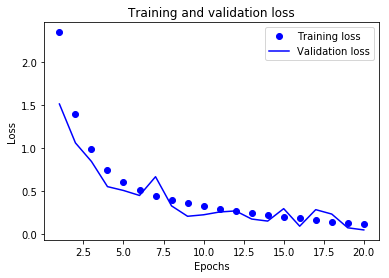

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

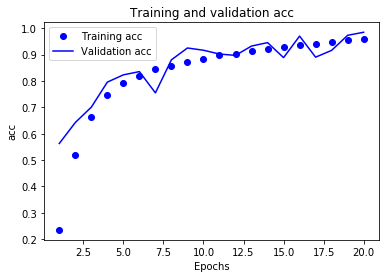

In [20]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()